# FEV vs. Semanticity Analysis

For each VGG19 layer, this notebook plots **mean FEV** vs. **silhouette score**.

- **Mean FEV** is taken from the regression: VGG19 features (reduced to N PCs) → PC1 Neural data

- For each layer, we select the **best FEV** (i.e., highest across PC counts)
  
- Silhouette score is calculated from TSNE-transformed, PCA-reduced VGG19 features. The number of PCs used is normalised across layers

- VGG19 features are extracted from 1,000 images from the STL10 dataset (10 classes, 100 images per class)

In [1]:
from cortexlib.stl10 import STL10FewShotDataset
from cortexlib.vgg19 import PreTrainedVGG19Model, PoolingMode
from cortexlib.tsne import TSNEVisualizer
from cortexlib.utils import file as futils
from cortexlib.utils.plotting import vgg19_colours
from cortexlib.utils.logging import Logger
import matplotlib.pyplot as plt
from adjustText import adjust_text
import pandas as pd

logger = Logger()

In [2]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

16:20:29 | INFO     | ℹ️ This notebook is running for mouse m02_d3


In [3]:
# For each layer, results has an FEV score for predicting neural data from VGG19 features reduced to N PCs
# Load results and filter the best FEV per layer (e.g. feats reduced to optimal number of PCs)
results = futils.read_json_file_as_dataframe('./prediction.json')
best_fev_per_layer = results.loc[results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
0,conv2_2,NaN,0.447306,0.487704
5,conv3_4,NaN,0.430649,0.469670
10,conv4_4,NaN,0.401695,0.438322
15,conv5_4,NaN,0.300184,0.328422
20,fc2,NaN,0.305729,0.334424


In [4]:
vgg19 = PreTrainedVGG19Model(pooling_mode=PoolingMode.AVGPOOL)

settings = vgg19.get_image_settings()

logger.progress("Loading STL10 images")
stl10 = STL10FewShotDataset(
    n_per_class=100, 
    size=settings['size'],
    channels=settings['channels'],
    normalise_mean=settings['mean'], 
    normalise_std=settings['std'],
)
logger.success("Loaded STL10 images")

/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/callummessiter/workspace/msc-neuro/research-project/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
16:20:30 | INFO     | ⏳ Loading STL10 images...


Files already downloaded and verified
Files already downloaded and verified


16:20:44 | SUCCESS  | ✅ Loaded STL10 images!


In [5]:
logger.progress("VGG19: extracting features from images shown to mouse")
vgg19_feats, labels = vgg19.extract_features_with_pooling(stl10.dataset)
logger.success("VGG19 features extracted")

for layer, feats in vgg19_feats.items():
    logger.info(f"{layer} feats shape: {tuple(feats.shape)}")

16:20:44 | INFO     | ⏳ VGG19: extracting features from images shown to mouse...


  0%|          | 0/63 [00:00<?, ?it/s]

16:23:02 | SUCCESS  | ✅ VGG19 features extracted!
16:23:02 | INFO     | ℹ️ conv2_2 feats shape: (1000, 128)
16:23:02 | INFO     | ℹ️ conv3_4 feats shape: (1000, 256)
16:23:02 | INFO     | ℹ️ conv4_4 feats shape: (1000, 512)
16:23:02 | INFO     | ℹ️ conv5_4 feats shape: (1000, 512)
16:23:02 | INFO     | ℹ️ fc2 feats shape: (1000, 4096)


In [6]:
# Map each label to its corresponding class name
class_labels = [stl10.class_names[label] for label in labels]

tsne_visualiser = TSNEVisualizer()
semanticity_results = []

logger.progress("Computing TSNE features from VGG-19 features")
for n_pcs in [10, 20, 50, 100]:
    logger.info(f"{n_pcs} PCs")
    
    tsne_feats = tsne_visualiser.compute_tsne(vgg19_feats, n_pca_components=n_pcs)
    silhouette_scores = tsne_visualiser.compute_silhouette_scores(tsne_feats, class_labels)

    for layer, score in silhouette_scores.items():
        semanticity_results.append({
            'layer': layer,
            'n_pcs': n_pcs,
            'silhouette_score': float(score) # json.dump() cannot serialize NumPy float32 types; convert to native Python floats first
        })

logger.success("TSNE features computed")

16:23:02 | INFO     | ⏳ Computing TSNE features from VGG-19 features...
16:23:02 | INFO     | ℹ️ 10 PCs
16:23:15 | INFO     | ℹ️ 20 PCs
16:23:27 | INFO     | ℹ️ 50 PCs
16:23:40 | INFO     | ℹ️ 100 PCs
16:23:52 | SUCCESS  | ✅ TSNE features computed!


In [7]:
semanticity_results_df = pd.DataFrame(semanticity_results)
semanticity_results_df.head(12)

,layer,n_pcs,silhouette_score
0,conv2_2,10,-0.098890
1,conv3_4,10,-0.071288
2,conv4_4,10,0.001955
3,conv5_4,10,0.269623
4,fc2,10,0.477962
5,conv2_2,20,-0.093797
6,conv3_4,20,-0.063128
7,conv4_4,20,0.004297
8,conv5_4,20,0.297036
9,fc2,20,0.481925


In [8]:
futils.write_json_file(semanticity_results, './semanticity.json')

In [9]:
# The dimensionality of features varies across model layers, so normalise it by the number of PCs used
semanticity_pcs = semanticity_results_df[semanticity_results_df['n_pcs'] == 100].reset_index(drop=True)
semanticity_pcs

,layer,n_pcs,silhouette_score
0,conv2_2,100,-0.090530
1,conv3_4,100,-0.055636
2,conv4_4,100,0.000313
3,conv5_4,100,0.252092
4,fc2,100,0.447020


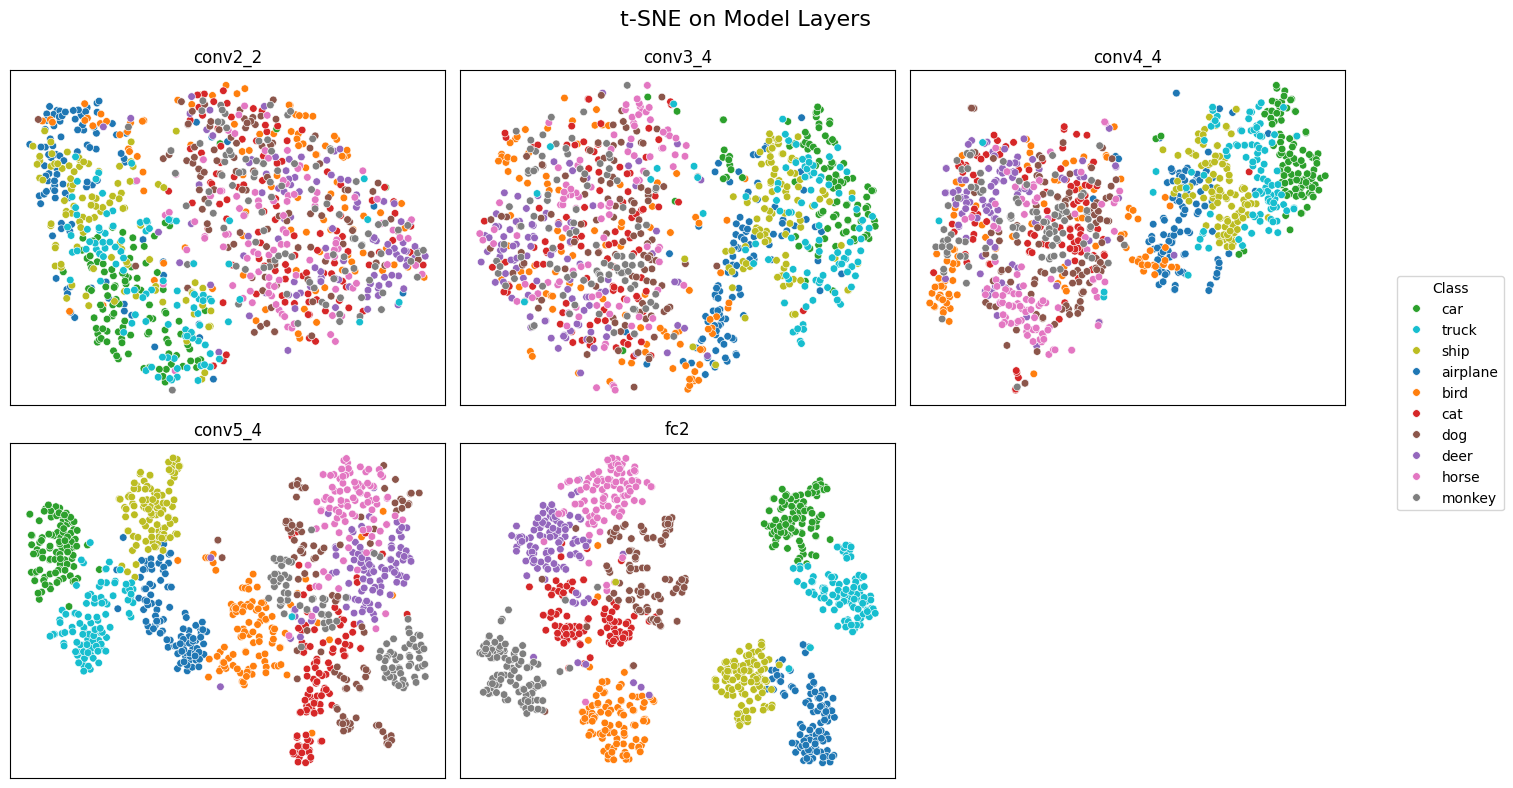

In [10]:
ordered_class_names = ['car', 'truck', 'ship', 'airplane', 'bird', 'cat',
                       'dog', 'deer', 'horse', 'monkey']

tsne_visualiser.plot_clusters_all_layers(tsne_feats, class_labels, custom_legend_order=ordered_class_names)

In [11]:
merged_results = pd.merge(best_fev_per_layer, semanticity_pcs, on='layer')
merged_results

,layer,n_pcs_x,test_r2,mean_fev,n_pcs_y,silhouette_score
0,conv2_2,NaN,0.447306,0.487704,100,-0.090530
1,conv3_4,NaN,0.430649,0.469670,100,-0.055636
2,conv4_4,NaN,0.401695,0.438322,100,0.000313
3,conv5_4,NaN,0.300184,0.328422,100,0.252092
4,fc2,NaN,0.305729,0.334424,100,0.447020


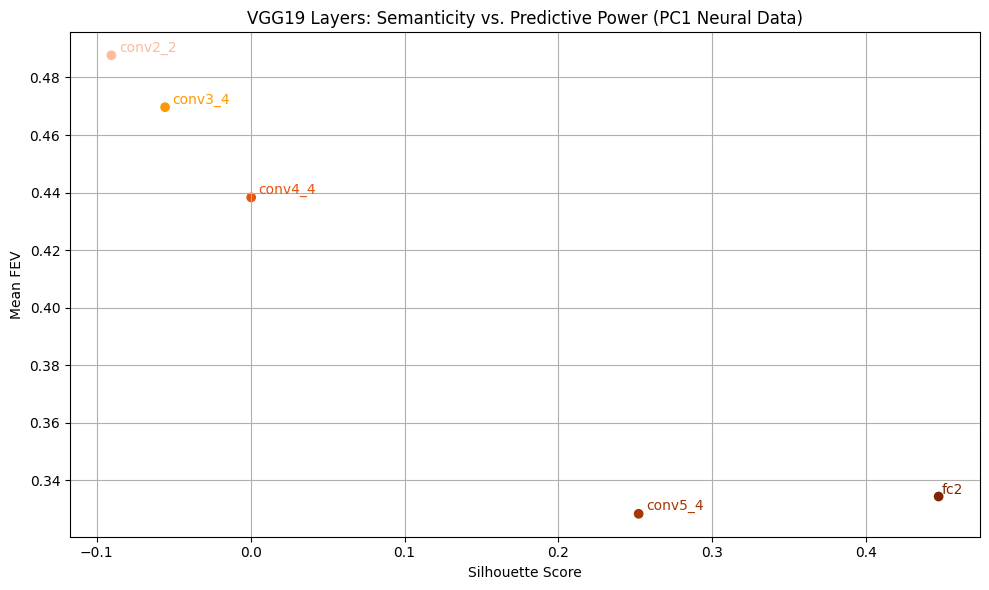

In [12]:
colours = merged_results['layer'].map(vgg19_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['silhouette_score'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['silhouette_score'], row['mean_fev'], row['layer'],
                 color=vgg19_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Silhouette Score')
plt.ylabel('Mean FEV')
plt.title('VGG19 Layers: Semanticity vs. Predictive Power (PC1 Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()